In [1]:
import time
import os
import sys
import pickle
import linecache
import pprint

import math

import re

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.corpus import stopwords
stop = stopwords.words('english')

from nltk.tokenize import word_tokenize
from gensim.models.doc2vec import Doc2Vec, TaggedDocument

from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.utils import shuffle
from sklearn.metrics import classification_report , accuracy_score , confusion_matrix , precision_score , f1_score

import xgboost as xgb

from skopt.space import Real, Categorical, Integer
from skopt import forest_minimize, gbrt_minimize, gp_minimize
from skopt.callbacks import DeltaYStopper
from skopt.utils import use_named_args

%matplotlib inline

c:\python\python37\lib\site-packages\sklearn\externals\joblib\__init__.py:15: DeprecationWarning: sklearn.externals.joblib is deprecated in 0.21 and will be removed in 0.23. Please import this functionality directly from joblib, which can be installed with: pip install joblib. If this warning is raised when loading pickled models, you may need to re-serialize those models with scikit-learn 0.21+.
  warnings.warn(msg, category=DeprecationWarning)


# Approach
### This solution uses a simple bag of words + xgboost for sentiment analysis
#### 1. Define Functions
#### 2. EDA
#### 3. Text Cleaning
#### 4. Hyper ParameterTuning
#### 5.Final Result


In [2]:
def PrintException():
    """
    Description : 
    - This function throws error without breaking the code. 
    - To be used for displaing errors in try-except blocks
    - Doesnot take any argument nor return anything
    """
    exc_type, exc_obj, tb = sys.exc_info()
    f = tb.tb_frame
    lineno = tb.tb_lineno
    filename = f.f_code.co_filename
    linecache.checkcache(filename)
    line = linecache.getline(filename, lineno, f.f_globals)
    print ('EXCEPTION IN ({}, LINE {} "{}"): {}'.format(filename, lineno, line.strip(), exc_obj))
    return

In [ ]:
def my_classification_report(y_actual , y_predicted):
    """
    Description : 
    - This function takes precdicted and actual values and gives key classification metrics
    
    Inputs:
    1. y_actual : Array of actual labels
    2. y_pred :  Array of predicted labels
    
    Outputs:
    1. Prescision , ecall, F1-Score and Accuracy metrics
    2. Plot of confusion matrix
    """
    
    print(classification_report(y_actual, y_pred))
    acc = accuracy_score(y_actual , y_predicted)
    print('accuracy : {}'.format(acc))
   
    conf_mat=confusion_matrix(y_actual, y_pred)
    #print(conf_mat)
    #plt.figure(figsize=(20,20))
    ax = plt.subplot()
    sns.heatmap(conf_mat, annot=True, ax = ax); #annot=True to annotate cells

    # labels, title and ticks
    ax.set_xlabel('Predicted labels')
    ax.set_ylabel('True labels')
    ax.set_title('Confusion Matrix')
    ax.xaxis.set_ticklabels(le.classes_)
    ax.yaxis.set_ticklabels(le.classes_)
    plt.xticks(rotation=90)
    plt.yticks(rotation=0)
    #plt.savefig('conf_matrix.png')
    plt.show()

In [3]:
data = pd.read_csv('./sentiment_analysis.csv'
                   , low_memory = False
                   )
data.head()

,airline_sentiment,airline,text
0,neutral,Virgin America,@VirginAmerica What @dhepburn said.
1,positive,Virgin America,@VirginAmerica plus you've added commercials t...
2,neutral,Virgin America,@VirginAmerica I didn't today... Must mean I n...
3,negative,Virgin America,@VirginAmerica it's really aggressive to blast...
4,negative,Virgin America,@VirginAmerica and it's a really big bad thing...


In [4]:
data.airline.unique()

array(['Virgin America', 'United', 'Southwest', 'Delta', 'US Airways',
       'American'], dtype=object)

In [5]:
data.airline_sentiment.unique()

array(['neutral', 'positive', 'negative'], dtype=object)

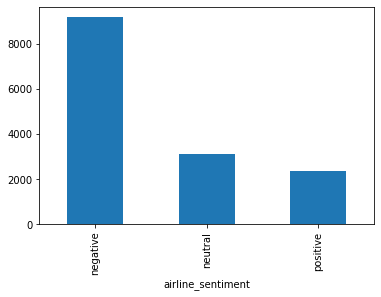

In [6]:
data.groupby('airline_sentiment')['text'].count().plot('bar')

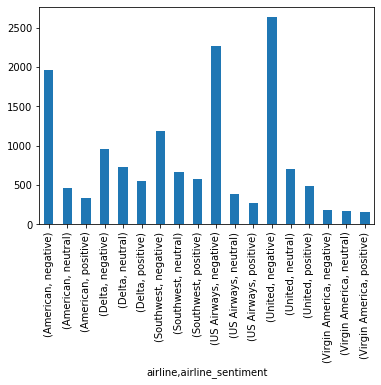

In [7]:
data.groupby(['airline','airline_sentiment'])['text'].count().plot('bar')
#ax = sns.barplot(x='airline', y="text", hue="airline_sentiment", data=data)

In [8]:
data = data[['airline_sentiment','text']]
data.head()

,airline_sentiment,text
0,neutral,@VirginAmerica What @dhepburn said.
1,positive,@VirginAmerica plus you've added commercials t...
2,neutral,@VirginAmerica I didn't today... Must mean I n...
3,negative,@VirginAmerica it's really aggressive to blast...
4,negative,@VirginAmerica and it's a really big bad thing...


In [9]:
#TEXT CLEANING

#Remove words starting with @ as they aree just references
data['cleaned_text'] = data['text'].apply(lambda x: ' '.join(word for word in x.split(' ') if not word.startswith('@')))

#Remove .
data['cleaned_text'] = data['cleaned_text'].str.lower().replace('.','')

#Remove Special Characters
data['cleaned_text'] = data['cleaned_text'].str.replace('[^\w\s]','')

#Stopword Removal
data['cleaned_text'] = data['cleaned_text'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))

#Visualize cleaned data
data.head()

,airline_sentiment,text,cleaned_text
0,neutral,@VirginAmerica What @dhepburn said.,said
1,positive,@VirginAmerica plus you've added commercials t...,plus youve added commercials experience tacky
2,neutral,@VirginAmerica I didn't today... Must mean I n...,didnt today must mean need take another trip
3,negative,@VirginAmerica it's really aggressive to blast...,really aggressive blast obnoxious entertainmen...
4,negative,@VirginAmerica and it's a really big bad thing...,really big bad thing


In [10]:
#Encode labels
le = LabelEncoder()
data['airline_sentiment_encoded'] = le.fit_transform( data['airline_sentiment'])
data.head()

,airline_sentiment,text,cleaned_text,airline_sentiment_encoded
0,neutral,@VirginAmerica What @dhepburn said.,said,1
1,positive,@VirginAmerica plus you've added commercials t...,plus youve added commercials experience tacky,2
2,neutral,@VirginAmerica I didn't today... Must mean I n...,didnt today must mean need take another trip,1
3,negative,@VirginAmerica it's really aggressive to blast...,really aggressive blast obnoxious entertainmen...,0
4,negative,@VirginAmerica and it's a really big bad thing...,really big bad thing,0


In [12]:
#HYPER PARAMETER OPTIMIZATION

#Define search space
skopt_grid_w = [Categorical(categories = [500,1000,2000,3000] , name='max_features')
                , Integer(low = 1, high = 3, name='n_grams')
                , Integer(low = 1, high = 10, name='max_depth')
                , Real(low = 0.001, high = 0.1, name='learning_rate')
                , Integer(low = 20, high = 300, name='n_estimators')
               ]

@use_named_args(skopt_grid_w)

def objective_function_w(**params):    
    
    """Description : This is objective function as skopt package is expecting"""
    
    try: 
        #Displa the current hyperparameters
        hyperparameters = (params['max_features']
                           , params['n_grams']
                           , params['max_depth']
                           , params['learning_rate']
                           , params['n_estimators']
                          )
        print('hyperparameters:', hyperparameters)

        try:
            #TFIDF Vectorization
            tfidf = TfidfVectorizer(max_features=params['max_features']
                        , lowercase=True
                        , analyzer='word'
                        , stop_words= 'english'
                        , ngram_range=(params['n_grams'],params['n_grams']))

            tfidf_matrix = tfidf.fit_transform(data['cleaned_text'])
            
            #Split data into train and validation sets
            Y = data['airline_sentiment_encoded']
            X = tfidf_matrix
            
            x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=7)
            
            #Define classifier here
            gbm = xgb.XGBClassifier(max_depth=params['max_depth']
                                    , learning_rate=params['learning_rate']
                                    ,n_estimators=params['n_estimators']
                                    )
            
            fitted_model = gbm.fit(x_train, y_train)
            y_pred = gbm.predict(x_val)
            
            #Choice of metric for tuning
            #metric = accuracy_score(y_val, y_pred, normalize=True)
            metric = f1_score(y_val ,y_pred , average = 'weighted')
            #metric = recall_score(y_val, y_pred , average = 'weighted')
            #metric = precision_score(y_val, y_pred , average = 'weighted')
            
            if math.isnan(metric):
                pass
            else:
                output_value = -metric
                
        except:
            PrintException()
            output_value = 0
        
        return output_value
    
    except:
        PrintException()
        
    return 0

In [16]:
hyperparam_opt_method_w = 'gp'
iterations = 31      


if hyperparam_opt_method_w == 'gp':
    optimization_result = gp_minimize(func = objective_function_w
                                      , dimensions = skopt_grid_w
                                      , n_calls=iterations
                                      , random_state=7
                                      , verbose=True)
    
elif hyperparam_opt_method_w == 'rf':
    optimization_result = forest_minimize(func = objective_function_w
                                      , dimensions = skopt_grid_w
                                      , n_calls=iterations
                                      , random_state=7
                                      , verbose=True
                                      , callback=None
                                     )
elif hyperparam_opt_method_w == 'gbm':
    optimization_result = gbrt_minimize(func = objective_function_w
                                      , dimensions = skopt_grid_w
                                      , n_calls=iterations
                                      , random_state=7
                                      , verbose=True
                                      , callback=None
                                   )

print('Current Params : ', optimization_result.x)

Iteration No: 1 started. Evaluating function at random point.
hyperparameters: (500, 2, 10, 0.04610290641949299, 106)
Iteration No: 1 ended. Evaluation done at random point.
Time taken: 4.2858
Function value obtained: -0.5287
Current minimum: -0.5287
Iteration No: 2 started. Evaluating function at random point.
hyperparameters: (1000, 1, 5, 0.0025751257351664192, 168)
Iteration No: 2 ended. Evaluation done at random point.
Time taken: 12.5326
Function value obtained: -0.6125
Current minimum: -0.6125
Iteration No: 3 started. Evaluating function at random point.
hyperparameters: (3000, 2, 5, 0.06775871187095653, 208)
Iteration No: 3 ended. Evaluation done at random point.
Time taken: 12.2195
Function value obtained: -0.5321
Current minimum: -0.6125
Iteration No: 4 started. Evaluating function at random point.
hyperparameters: (2000, 2, 9, 0.026995793234296316, 230)
Iteration No: 4 ended. Evaluation done at random point.
Time taken: 16.3956
Function value obtained: -0.5240
Current minimum

c:\python\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration No: 8 ended. Evaluation done at random point.
Time taken: 0.9283
Function value obtained: -0.4892
Current minimum: -0.6125
Iteration No: 9 started. Evaluating function at random point.
hyperparameters: (2000, 2, 4, 0.09217836047299362, 141)
Iteration No: 9 ended. Evaluation done at random point.
Time taken: 5.8159
Function value obtained: -0.5238
Current minimum: -0.6125
Iteration No: 10 started. Evaluating function at random point.
hyperparameters: (1000, 3, 8, 0.03498720505364812, 104)
Iteration No: 10 ended. Evaluation done at random point.
Time taken: 4.2970
Function value obtained: -0.4976
Current minimum: -0.6125
Iteration No: 11 started. Searching for the next optimal point.
hyperparameters: (500, 1, 10, 0.1, 300)
Iteration No: 11 ended. Search finished for the next optimal point.
Time taken: 27.3964
Function value obtained: -0.7123
Current minimum: -0.7123
Iteration No: 12 started. Searching for the next optimal point.
hyperparameters: (500, 1, 10, 0.1, 20)
Iteration 

c:\python\python37\lib\site-packages\sklearn\metrics\classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


Iteration No: 21 ended. Search finished for the next optimal point.
Time taken: 1.4029
Function value obtained: -0.5676
Current minimum: -0.7200
Iteration No: 22 started. Searching for the next optimal point.
hyperparameters: (3000, 1, 10, 0.1, 300)
Iteration No: 22 ended. Search finished for the next optimal point.
Time taken: 58.5847
Function value obtained: -0.7255
Current minimum: -0.7255
Iteration No: 23 started. Searching for the next optimal point.
hyperparameters: (3000, 1, 8, 0.1, 300)
Iteration No: 23 ended. Search finished for the next optimal point.
Time taken: 48.4373
Function value obtained: -0.7226
Current minimum: -0.7255
Iteration No: 24 started. Searching for the next optimal point.
hyperparameters: (2000, 1, 8, 0.09996529974005053, 242)
Iteration No: 24 ended. Search finished for the next optimal point.
Time taken: 33.0352
Function value obtained: -0.7050
Current minimum: -0.7255
Iteration No: 25 started. Searching for the next optimal point.
hyperparameters: (1000, 

c:\python\python37\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 25 ended. Search finished for the next optimal point.
Time taken: 38.7285
Function value obtained: -0.7200
Current minimum: -0.7255
Iteration No: 26 started. Searching for the next optimal point.
hyperparameters: (3000, 1, 10, 0.008125920038115894, 288)
Iteration No: 26 ended. Search finished for the next optimal point.
Time taken: 58.4822
Function value obtained: -0.6261
Current minimum: -0.7255
Iteration No: 27 started. Searching for the next optimal point.
hyperparameters: (1000, 1, 10, 0.1, 300)


c:\python\python37\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 27 ended. Search finished for the next optimal point.
Time taken: 38.1130
Function value obtained: -0.7200
Current minimum: -0.7255
Iteration No: 28 started. Searching for the next optimal point.
hyperparameters: (500, 3, 8, 0.09831549336723178, 28)
Iteration No: 28 ended. Search finished for the next optimal point.
Time taken: 1.3205
Function value obtained: -0.4976
Current minimum: -0.7255
Iteration No: 29 started. Searching for the next optimal point.
hyperparameters: (3000, 3, 9, 0.0027247889840579485, 299)
Iteration No: 29 ended. Search finished for the next optimal point.
Time taken: 22.2686
Function value obtained: -0.4952
Current minimum: -0.7255
Iteration No: 30 started. Searching for the next optimal point.
hyperparameters: (2000, 1, 10, 0.1, 300)


c:\python\python37\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 30 ended. Search finished for the next optimal point.
Time taken: 48.9124
Function value obtained: -0.7194
Current minimum: -0.7255
Iteration No: 31 started. Searching for the next optimal point.
hyperparameters: (1000, 1, 10, 0.1, 300)


c:\python\python37\lib\site-packages\skopt\optimizer\optimizer.py:399: UserWarning: The objective has been evaluated at this point before.
  warnings.warn("The objective has been evaluated "


Iteration No: 31 ended. Search finished for the next optimal point.
Time taken: 38.1790
Function value obtained: -0.7200
Current minimum: -0.7255
Current Params :  [3000, 1, 10, 0.1, 300]
Best Params: (3000, 1, 10, 0.1, 300)


In [18]:
#Catch best parameters in a tuple
best_params = (optimization_result.x[0]
               , optimization_result.x[1]
               , optimization_result.x[2]
               , optimization_result.x[3]
               , optimization_result.x[4])

print('Best Params:', best_params)

Best Params: (3000, 1, 10, 0.1, 300)


              precision    recall  f1-score   support

           0       0.77      0.92      0.84      1834
           1       0.65      0.35      0.45       628
           2       0.69      0.60      0.64       466

    accuracy                           0.75      2928
   macro avg       0.70      0.62      0.64      2928
weighted avg       0.73      0.75      0.73      2928

accuracy : 0.7472677595628415


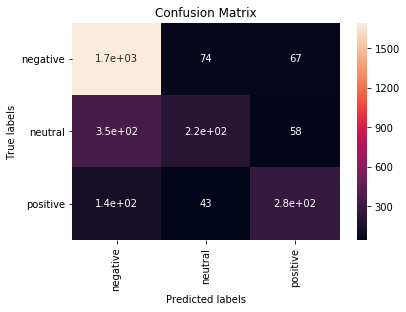

In [17]:
#FINAL RESULT

#Pick the best parameters
tfidf = TfidfVectorizer(max_features=best_params[0]
                        , lowercase=True
                        , analyzer='word'
                        , stop_words= 'english'
                        , ngram_range=(best_params[1],best_params[1]))

tfidf_matrix = tfidf.fit_transform(data['cleaned_text'])
            
Y = data['airline_sentiment_encoded']
X = tfidf_matrix
            
x_train, x_val, y_train, y_val = train_test_split(X, Y, test_size=0.2, random_state=7)
            
gbm = xgb.XGBClassifier(max_depth=int(best_params[2])
                        , learning_rate=best_params[3]
                        , n_estimators=best_params[4]
                       )
gbm.fit(x_train , y_train)
y_pred = gbm.predict(x_val)
my_classification_report(y_actual = y_val , y_predicted = y_pred)